<a href="https://colab.research.google.com/github/akshaypt7/customer_relationship_prediction/blob/main/XG%20Boost%20for%20Churn.ipynb" target="_parent"><img src="https://colab.research.google.com/assets/colab-badge.svg" alt="Open In Colab"/></a>

In [117]:
import pandas as pd
import numpy as np
import pickle

from sklearn.model_selection import GridSearchCV
from sklearn.model_selection import train_test_split
from sklearn.metrics import confusion_matrix, fbeta_score, make_scorer, precision_recall_curve, average_precision_score
from sklearn.pipeline import Pipeline
from sklearn.preprocessing import StandardScaler, OneHotEncoder
from sklearn.compose import ColumnTransformer
from sklearn.linear_model import LogisticRegression

from sklearn.ensemble import RandomForestClassifier, GradientBoostingClassifier
from sklearn.preprocessing import OrdinalEncoder

from imblearn.over_sampling import RandomOverSampler
from imblearn.under_sampling import RandomUnderSampler
from sklearn.preprocessing import OrdinalEncoder

import matplotlib as mpl
import matplotlib.cm as cm
import matplotlib.pyplot as plt
from IPython.display import display, HTML
import seaborn as sns

from sklearn.metrics import roc_curve, auc, classification_report

In [65]:
# from google.colab import drive
# drive.mount('/content/drive')

In [66]:
f2_score = make_scorer(fbeta_score, beta=2)

In [67]:
df_train = pd.read_csv('/content/drive/MyDrive/Colab files/Project - ML2/orange_small_train.data', sep='\t')
# df_train = pd.read_csv('/content/drive/MyDrive/UnivAI/ML-2 project/data/orange_small_train.data', sep='\t')

In [68]:
df_train.head()

,Var1,Var2,Var3,Var4,Var5,Var6,Var7,Var8,Var9,Var10,Var11,Var12,Var13,Var14,Var15,Var16,Var17,Var18,Var19,Var20,Var21,Var22,Var23,Var24,Var25,Var26,Var27,Var28,Var29,Var30,Var31,Var32,Var33,Var34,Var35,Var36,Var37,Var38,Var39,Var40,...,Var191,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var209,Var210,Var211,Var212,Var213,Var214,Var215,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var224,Var225,Var226,Var227,Var228,Var229,Var230
0,NaN,NaN,NaN,NaN,NaN,1526.0,7.0,NaN,NaN,NaN,NaN,NaN,184.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,464.0,580.0,NaN,14.0,128.0,NaN,NaN,166.56,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,3570.0,NaN,NaN,...,NaN,bZkvyxLkBI,RO12,NaN,taul,1K8T,lK27,ka_ns41,nQUveAzAF7,NaN,NaN,dXGu,9_Y1,FbIm,VpdQ,haYg,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,NaN,NaN,XTbPUYD,sH5Z,cJvF,FzaX,1YVfGrO,oslk,fXVEsaq,jySVZNlOJy,NaN,NaN,xb3V,RAYp,F2FyR07IdsN7I,NaN,NaN
1,NaN,NaN,NaN,NaN,NaN,525.0,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,168.0,210.0,NaN,2.0,24.0,NaN,NaN,353.52,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,4764966.0,NaN,NaN,...,NaN,CEat0G8rTN,RO12,NaN,taul,1K8T,2Ix5,qEdASpP,y2LIM01bE1,NaN,NaN,lg1t,9_Y1,k13i,sJzTlal,zm5i,me75fM6ugJ,kIsH,NaN,uKAI,L84s,NhsEn4L,NaN,NaN,NaN,kZJyVg2,NaN,NaN,FzaX,0AJo2f2,oslk,2Kb5FSF,LM8l689qOp,NaN,NaN,fKCe,RAYp,F2FyR07IdsN7I,NaN,NaN
2,NaN,NaN,NaN,NaN,NaN,5236.0,7.0,NaN,NaN,NaN,NaN,NaN,904.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,1212.0,1515.0,NaN,26.0,816.0,NaN,NaN,220.08,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,5883894.0,NaN,NaN,...,NaN,eOQt0GoOh3,AERks4l,SEuy,taul,1K8T,ffXs,NldASpP,y4g9XoZ,vynJTq9,smXZ,4bTR,9_Y1,MGOA,VpdQ,haYg,DHn_WUyBhW_whjA88g9bvA64_,kIsH,NaN,uKAI,L84s,UbxQ8lZ,NaN,TTGHfSv,NaN,pMWAe2U,bHR7,UYBR,FzaX,JFM1BiF,Al6ZaUT,NKv4yOc,jySVZNlOJy,NaN,kG3k,Qu4f,02N6s8f,ib5G6X1eUxUn6,am7c,NaN
3,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,22.08,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,jg69tYsGvO,RO12,NaN,taul,1K8T,ssAy,_ybO0dd,4hMlgkf58mhwh,NaN,NaN,W8mQ,9_Y1,YULl,VpdQ,NaN,me75fM6ugJ,kIsH,NaN,uKAI,Mtgm,NhsEn4L,NaN,NaN,NaN,kq0dQfu,eKej,UYBR,FzaX,L91KIiz,oslk,CE7uk3u,LM8l689qOp,NaN,NaN,FSa2,RAYp,F2FyR07IdsN7I,NaN,NaN
4,NaN,NaN,NaN,NaN,NaN,1029.0,7.0,NaN,NaN,NaN,NaN,NaN,3216.0,NaN,NaN,NaN,NaN,NaN,NaN,NaN,64.0,80.0,NaN,4.0,64.0,NaN,NaN,200.00,NaN,NaN,NaN,NaN,NaN,NaN,0.0,NaN,NaN,0.0,NaN,NaN,...,NaN,IXSgUHShse,RO12,SEuy,taul,1K8T,uNkU,EKR938I,ThrHXVS,0v21jmy,smXZ,xklU,9_Y1,RVjC,sJzTlal,6JmL,me75fM6ugJ,kIsH,NaN,uKAI,L84s,XfqtO3UdzaXh_,NaN,SJs3duv,NaN,11p4mKe,H3p7,UYBR,FzaX,OrnLfvc,oslk,1J2cvxe,LM8l689qOp,NaN,kG3k,FSa2,RAYp,F2FyR07IdsN7I,mj86,NaN


In [69]:
y_train_churn = pd.read_table('/content/drive/MyDrive/Colab files/Project - ML2/orange_small_train_churn.labels', header = None).loc[:, 0].astype('category')
# y_train_churn = pd.read_table('/content/drive/MyDrive/UnivAI/ML-2 project/data/orange_small_train_churn.labels', header = None).loc[:, 0].astype('category')
y_train_churn.head()

0   -1
1    1
2   -1
3   -1
4   -1
Name: 0, dtype: category
Categories (2, int64): [-1, 1]

In [70]:
# y_train_appetency =pd.read_table('/content/drive/MyDrive/UnivAI/ML-2 project/data/orange_small_train_appetency.labels',header = None).loc[:, 0].astype('category')
# y_train_appetency.head()

In [71]:
# y_train_upselling= pd.read_table('/content/drive/MyDrive/UnivAI/ML-2 project/data/orange_small_train_upselling.labels', header = None).loc[:, 0].astype('category')
# y_train_upselling.head()

In [72]:
# df_test = pd.read_table('/content/drive/MyDrive/UnivAI/ML-2 project/data/orange_small_test.data')
# df_test.head()

Change the lables from [-1, 1] to [0, 1]

In [73]:
# y_train_appetency = (y_train_appetency.astype('int') + 1)/2
y_train_churn = (y_train_churn.astype('int') + 1)/2
# y_train_upselling = (y_train_upselling.astype('int') + 1)/2

In [74]:
# y_train_appetency.tail()

In [75]:
# np.mean(y_train_appetency == 1) , np.mean(y_train_churn == 1) , np.mean(y_train_upselling == 1)

In [76]:
print(np.mean(y_train_churn == 1))
print(y_train_churn.value_counts())

0.07344
0.0    46328
1.0     3672
Name: 0, dtype: int64


In [77]:
# y_train_appetency.value_counts()

In [78]:
# y_train_upselling.value_counts()

In [79]:
# fig, axes = plt.subplots(1,3, figsize=(20,6))
# axes[0].hist(y_train_churn, bins=3)
# axes[0].set_title('Churn Label distribution')
# axes[1].hist(y_train_appetency, bins=3)
# axes[1].set_title('Appetency Label distribution')
# axes[2].hist(y_train_upselling, bins=3)
# axes[2].set_title('Upselling label distribution')
# plt.show()

### Preprocessing

In [80]:
def pretty_print(df):
    return display( HTML( df.to_html().replace("\\n","<br>") ) )

In [81]:
def tbl_report(tbl, cols=None, card=10):
    print("Table Shape", tbl.shape)
    dtypes = tbl.dtypes
    nulls = []
    uniques = []
    numuniques = []
    vcs = []
    for col in dtypes.index:
        n = tbl[col].isnull().sum()
        nulls.append(n)
        strdtcol = str(dtypes[col])
        #if strdtcol == 'object' or strdtcol[0:3] == 'int' or strdtcol[0:3] == 'int':
        #print(strdtcol)
        uniqs = tbl[col].unique()
        uniquenums = uniqs.shape[0]
        if uniquenums < card: # low cardinality
            valcounts = pd.value_counts(tbl[col], dropna=False)
            vc = "\n".join(["{}:{}".format(k,v) for k, v in valcounts.items()])
        else:
            vc='HC' # high cardinality
        uniques.append(uniqs)
        numuniques.append(uniquenums)
        vcs.append(vc)
    nullseries = pd.Series(nulls, index=dtypes.index)
    uniqueseries = pd.Series(uniques, index=dtypes.index)
    numuniqueseries = pd.Series(numuniques, index=dtypes.index)
    vcseries = pd.Series(vcs, index=dtypes.index)
    df = pd.concat([dtypes, nullseries, uniqueseries, numuniqueseries, vcseries], axis=1)
    df.columns = ['dtype', 'nulls', 'uniques', 'num_uniques', 'value_counts']
    if cols:
        return df[cols]
    return df


In [82]:
pretty_print(tbl_report(df_train, cols=['dtype', 'nulls', 'num_uniques', 'value_counts']))

Table Shape (50000, 230)


,dtype,nulls,num_uniques,value_counts
Var1,float64,49298,19,HC
Var2,float64,48759,3,nan:487590.0:12405.0:1
Var3,float64,48760,147,HC
Var4,float64,48421,5,nan:484210.0:15619.0:1518.0:227.0:1
Var5,float64,48513,572,HC
Var6,float64,5529,1487,HC
Var7,float64,5539,9,7.0:235300.0:13090nan:553914.0:504921.0:182528.0:70335.0:262140.0:142.0:1
Var8,float64,50000,1,nan:50000
Var9,float64,49298,101,HC
Var10,float64,48513,535,HC


Table Shape (50000, 230)


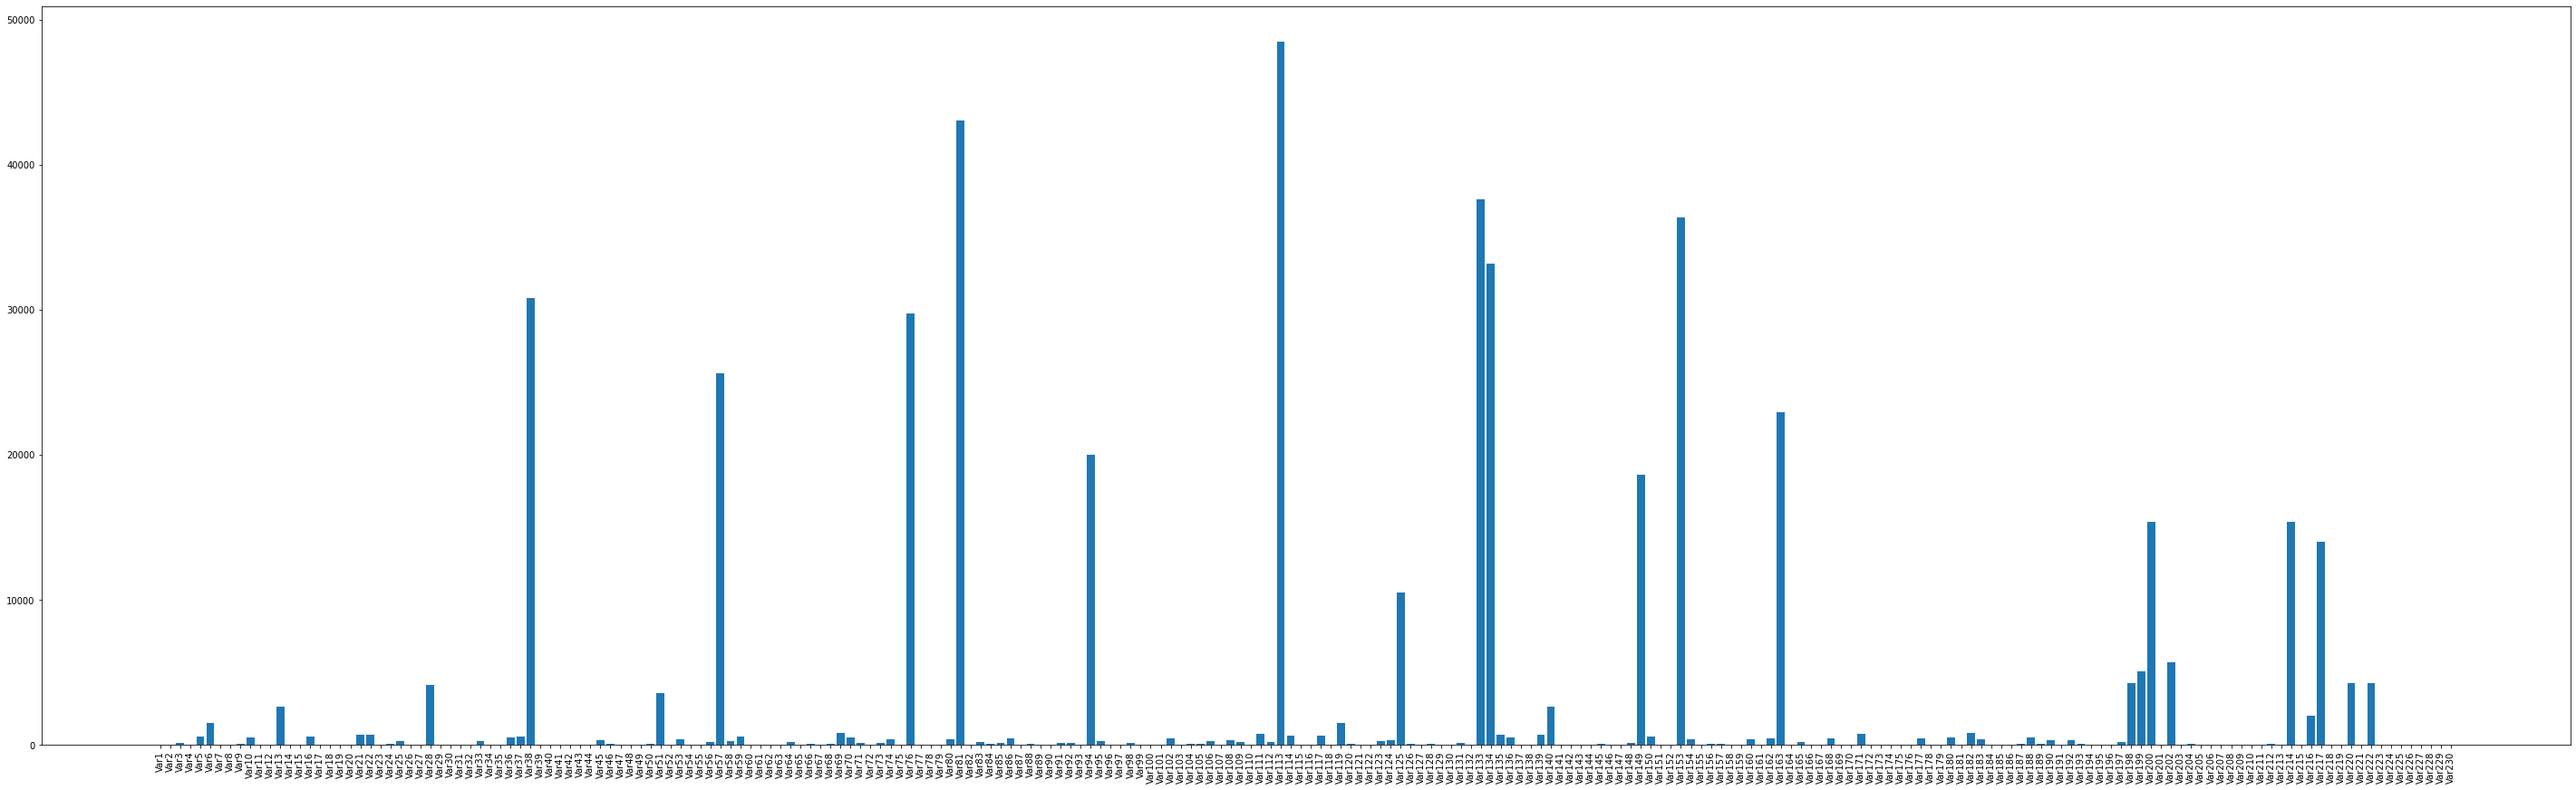

In [83]:
table_report = tbl_report(df_train, cols=['dtype', 'nulls', 'num_uniques', 'value_counts'])

plt.figure(figsize=(50,15))
plt.bar(table_report.index, table_report['num_uniques'])
plt.xticks(rotation=90, fontsize=10)
plt.show()

In [84]:
df_table = tbl_report(df_train, cols=['dtype', 'nulls', 'num_uniques', 'value_counts']) # Using the second tbl_report function

df_table['dtype'].value_counts()

Table Shape (50000, 230)


float64    191
object      38
int64        1
Name: dtype, dtype: int64

In [85]:
df_float = df_table[df_table['dtype']== 'float64']
lst_empty_float_cols = list(df_float[df_float['nulls'] > len(df_train)*0.95 ].index)
print("Number of float cols where more than 95% of data is null = ",len(lst_empty_float_cols))

Number of float cols where more than 95% of data is null =  149


In [86]:
df_object = df_table[df_table['dtype']== 'object']
lst_empty_categorical_cols = list(df_object[df_object['nulls'] > len(df_train)*0.95 ].index)
print("Number of categorical cols where more than 95% of data is null = ",len(lst_empty_categorical_cols))

Number of categorical cols where more than 95% of data is null =  4


In [87]:
drop_cols = lst_empty_float_cols + lst_empty_categorical_cols
print("Total columns to be dropped =",len(drop_cols))

Total columns to be dropped = 153


In [88]:
df_train_kdd = df_train.drop(drop_cols,axis=1)

In [89]:
categorical_cols = list(df_train_kdd.dtypes[df_train_kdd.dtypes == 'object'].index)
continuous_cols = list(df_train_kdd.dtypes[(df_train_kdd.dtypes == 'float64') | (df_train_kdd.dtypes == 'int64')].index)

In [90]:
df_train_cat_cols = df_train_kdd[categorical_cols].fillna('o')

In [91]:
encoder = OrdinalEncoder()
# transform data
encoder.fit(df_train_cat_cols)
encoded_train_cat_cols = encoder.transform(df_train_cat_cols)

In [92]:
df_train_kdd[categorical_cols] = pd.DataFrame(encoded_train_cat_cols, columns=categorical_cols)


In [93]:
X_train, X_val, y_train, y_val = train_test_split(df_train_kdd, y_train_churn, random_state=66, train_size=0.8, stratify=y_train_churn)


In [94]:
X_train = X_train.fillna(X_train.mean())
X_val = X_val.fillna(X_train.mean())

In [95]:
def upsample_downsample(X, y):
    # define oversampling strategy
    over_sample = RandomOverSampler(sampling_strategy=0.2)
    X_over, y_over = over_sample.fit_resample(X, y)

    # define under sampling strategy
    under_sample = RandomUnderSampler(sampling_strategy=0.5)
    X_balanced, y_balanced = under_sample.fit_resample(X_over, y_over)
    return X_balanced, y_balanced

In [96]:
X_train.head()

,Var6,Var7,Var13,Var21,Var22,Var24,Var25,Var28,Var35,Var38,Var44,Var51,Var57,Var65,Var72,Var73,Var74,Var76,Var78,Var81,Var83,Var85,Var94,Var109,Var112,Var113,Var119,Var123,Var125,Var126,Var132,Var133,Var134,Var140,Var143,Var144,Var149,Var153,Var160,Var163,Var173,Var181,Var189,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var210,Var211,Var212,Var214,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var225,Var226,Var227,Var228,Var229
35505,343.0,7.0,1488.0,84.0,105.0,2.0,128.0,200.00,0.0,0.0,0.0,42536.253515,5.836574,9.0,4.187324,92,0.0,7904.0,0.0,3694.35,0.0,4.0,99161.216747,16.0,8.0,3364.716,290.0,0.0,2430.0,68.000000,0.0,6995.0,43974.0,1435.0,0.0,9.0,2324.0,102112.0,4.0,6924.0,0.0,0.0,336.000000,209.0,25.0,3.0,22.0,0.0,177.0,3216.0,1291.0,9964.0,1.0,5545.0,0.0,35.0,1.0,18.0,10.0,0.0,5.0,0.0,33.0,685.0,1418.0,4752.0,1.0,11.0,2246.0,4.0,3910.0,0.0,0.0,1.0,2.0,8.0,0.0
28064,1442.0,7.0,792.0,172.0,215.0,6.0,64.0,286.96,0.0,5789556.0,0.0,42536.253515,2.024354,9.0,4.187324,56,168.0,2550296.0,0.0,138998.40,10.0,18.0,99161.216747,88.0,48.0,94877.200,905.0,78.0,92817.0,-30.000000,0.0,1980105.0,1109132.0,635.0,0.0,18.0,1309861.0,10533160.0,10.0,1443474.0,0.0,0.0,270.523569,95.0,25.0,1.0,22.0,0.0,222.0,461.0,1073.0,1938.0,2.0,5134.0,0.0,41.0,1.0,10.0,10.0,0.0,5.0,0.0,44.0,14591.0,6.0,1355.0,1.0,11.0,4059.0,4.0,840.0,3.0,3.0,4.0,2.0,8.0,0.0
27185,1946.0,0.0,0.0,296.0,370.0,2.0,56.0,200.00,0.0,7820820.0,0.0,42536.253515,0.021363,9.0,4.187324,78,0.0,983160.0,0.0,82460.09,40.0,4.0,99161.216747,56.0,72.0,71299.200,1960.0,120.0,7740.0,-0.528886,0.0,1287575.0,532514.0,0.0,0.0,0.0,152208.0,10436720.0,56.0,449868.0,0.0,0.0,138.000000,95.0,25.0,1.0,22.0,0.0,207.0,2641.0,750.0,10135.0,2.0,1940.0,0.0,0.0,0.0,6.0,10.0,0.0,5.0,0.0,33.0,5712.0,1544.0,4598.0,0.0,11.0,3823.0,4.0,2385.0,1.0,1.0,4.0,2.0,8.0,1.0
42938,336.0,7.0,16.0,76.0,95.0,2.0,32.0,200.00,0.0,19914.0,0.0,42536.253515,4.088016,9.0,4.187324,116,0.0,19112.0,0.0,6333.84,0.0,0.0,99161.216747,16.0,16.0,-10617.000,385.0,6.0,5265.0,42.000000,0.0,123910.0,59742.0,25.0,0.0,9.0,1050.0,241444.0,24.0,0.0,0.0,0.0,270.523569,330.0,0.0,1.0,22.0,0.0,217.0,1531.0,3246.0,3100.0,2.0,5022.0,0.0,6.0,0.0,3.0,5.0,0.0,5.0,0.0,18.0,9941.0,212.0,4381.0,0.0,11.0,232.0,3.0,4242.0,0.0,1.0,10.0,4.0,2.0,0.0
7183,203.0,0.0,0.0,20.0,25.0,0.0,16.0,230.56,0.0,881166.0,0.0,42536.253515,3.230506,27.0,9.000000,22,0.0,0.0,0.0,190752.30,0.0,0.0,405183.000000,0.0,0.0,-111240.800,215.0,6.0,0.0,-2.000000,0.0,3490395.0,2388380.0,0.0,0.0,9.0,0.0,8156520.0,4.0,0.0,0.0,0.0,270.523569,135.0,25.0,3.0,22.0,0.0,64.0,1844.0,1191.0,12515.0,1.0,5610.0,0.0,36.0,1.0,21.0,10.0,0.0,5.0,1.0,33.0,12581.0,180.0,5862.0,0.0,11.0,2502.0,4.0,2859.0,0.0,2.0,12.0,2.0,8.0,2.0


In [97]:
X_balanced, y_balanced = upsample_downsample(X_train, y_train)

/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)
/usr/local/lib/python3.7/dist-packages/sklearn/utils/deprecation.py:87: FutureWarning: Function safe_indexing is deprecated; safe_indexing is deprecated in version 0.22 and will be removed in version 0.24.
  warnings.warn(msg, category=FutureWarning)


In [98]:
X_balanced = pd.DataFrame(X_balanced,columns=X_train.columns)

In [99]:
cont_cols_df_X = X_balanced[continuous_cols]

###Standard Scaler

In [100]:
scaler = StandardScaler()
scaler.fit(cont_cols_df_X)
scaled_X_balanced = scaler.transform(cont_cols_df_X)

In [101]:
X_balanced_scaled = pd.DataFrame(scaled_X_balanced,columns=continuous_cols).join(X_balanced[categorical_cols])
X_balanced_scaled.columns = X_balanced.columns

In [102]:
X_val[categorical_cols]

,Var192,Var193,Var194,Var195,Var196,Var197,Var198,Var199,Var200,Var201,Var202,Var203,Var204,Var205,Var206,Var207,Var208,Var210,Var211,Var212,Var214,Var216,Var217,Var218,Var219,Var220,Var221,Var222,Var223,Var225,Var226,Var227,Var228,Var229
12489,112.0,25.0,3.0,22.0,0.0,2.0,3213.0,2452.0,12515.0,1.0,2275.0,1.0,40.0,1.0,21.0,10.0,0.0,5.0,0.0,33.0,12581.0,499.0,8070.0,0.0,11.0,4008.0,4.0,1066.0,0.0,2.0,8.0,2.0,8.0,2.0
12300,69.0,25.0,3.0,22.0,0.0,17.0,3148.0,2120.0,11110.0,1.0,542.0,0.0,15.0,0.0,10.0,4.0,0.0,5.0,0.0,6.0,5170.0,168.0,2469.0,0.0,11.0,2836.0,5.0,1730.0,0.0,0.0,11.0,3.0,11.0,1.0
27701,79.0,0.0,3.0,22.0,0.0,27.0,499.0,542.0,6221.0,1.0,3888.0,0.0,88.0,0.0,10.0,10.0,0.0,5.0,0.0,44.0,3296.0,788.0,303.0,1.0,11.0,2464.0,4.0,1092.0,0.0,0.0,10.0,2.0,2.0,0.0
2577,265.0,25.0,3.0,22.0,0.0,2.0,2057.0,2882.0,12515.0,1.0,2689.0,1.0,87.0,1.0,6.0,10.0,0.0,5.0,0.0,33.0,12581.0,1305.0,6748.0,0.0,11.0,571.0,4.0,2191.0,0.0,2.0,18.0,2.0,8.0,2.0
46964,208.0,0.0,3.0,22.0,0.0,78.0,3477.0,3159.0,4907.0,1.0,4690.0,0.0,6.0,1.0,19.0,4.0,0.0,5.0,1.0,60.0,10171.0,307.0,7750.0,1.0,11.0,1250.0,4.0,2307.0,1.0,0.0,10.0,2.0,14.0,0.0
...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...,...
35516,236.0,25.0,1.0,22.0,0.0,217.0,17.0,998.0,4785.0,2.0,5614.0,0.0,59.0,3.0,18.0,10.0,0.0,5.0,0.0,33.0,3864.0,895.0,3304.0,1.0,11.0,2712.0,4.0,2745.0,0.0,3.0,10.0,2.0,8.0,2.0
27230,336.0,25.0,3.0,22.0,0.0,17.0,2393.0,3593.0,12515.0,1.0,5482.0,0.0,95.0,1.0,16.0,10.0,0.0,5.0,0.0,33.0,12581.0,1305.0,12587.0,1.0,11.0,922.0,4.0,4171.0,0.0,2.0,2.0,2.0,8.0,2.0
16778,323.0,25.0,1.0,22.0,0.0,17.0,456.0,3477.0,8080.0,2.0,3285.0,0.0,46.0,1.0,6.0,10.0,0.0,5.0,0.0,33.0,9508.0,672.0,5472.0,0.0,11.0,1666.0,4.0,2313.0,1.0,1.0,6.0,2.0,8.0,0.0
12699,345.0,0.0,3.0,22.0,0.0,222.0,2782.0,137.0,11134.0,1.0,311.0,0.0,0.0,1.0,14.0,10.0,0.0,5.0,0.0,44.0,670.0,6.0,11804.0,1.0,11.0,544.0,4.0,1954.0,0.0,0.0,4.0,2.0,2.0,2.0


In [103]:
X_val = X_val.reset_index().drop('index', axis=1)

In [104]:
X_val_scaled = pd.DataFrame(scaler.transform(X_val[continuous_cols])).join(X_val[categorical_cols])
X_val_scaled.columns = X_balanced.columns

In [105]:
!pip install rfpimp
from rfpimp import plot_corr_heatmap, plot_dependence_heatmap, feature_dependence_matrix, feature_corr_matrix

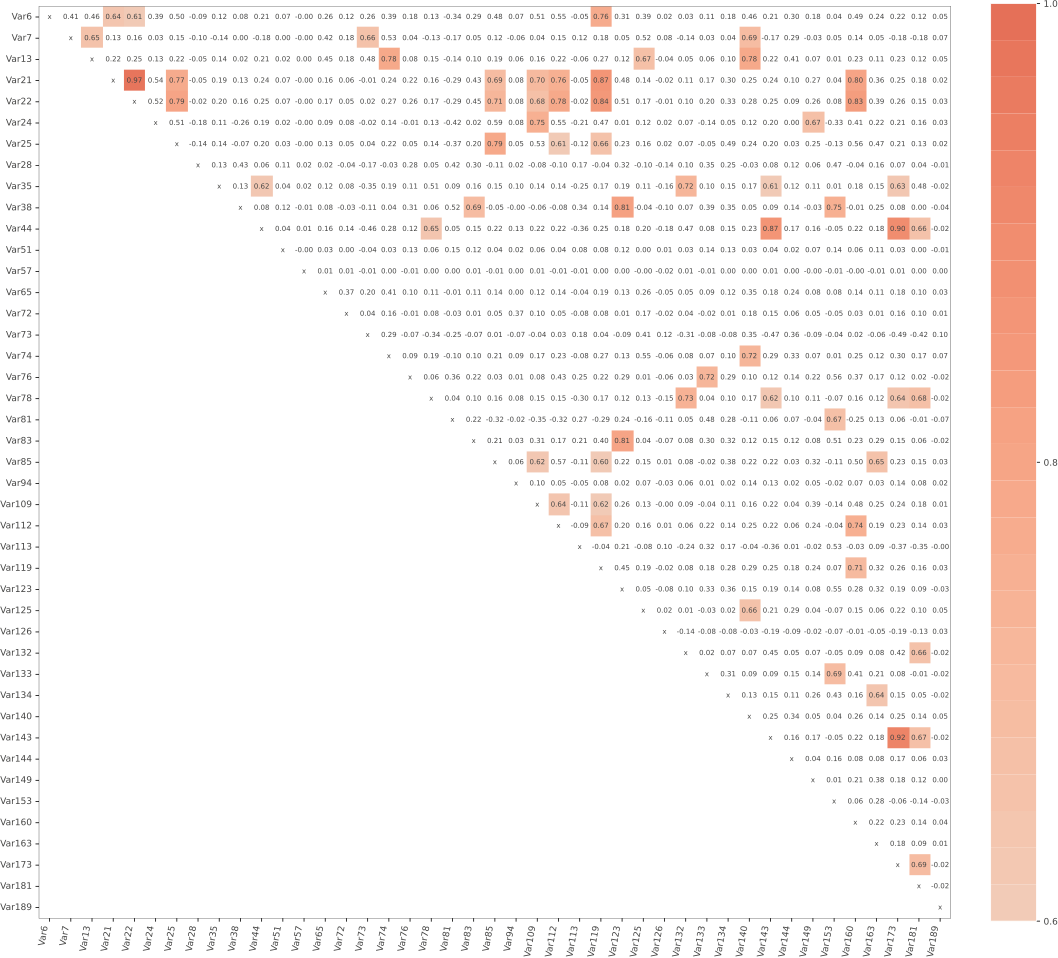

In [106]:
viz = plot_corr_heatmap(X_balanced_scaled[continuous_cols], figsize=(15,15), label_fontsize=9, value_fontsize=7)
viz

In [107]:
corr_matrix = feature_corr_matrix(X_balanced_scaled).abs()

# Select upper triangle of correlation matrix
upper = corr_matrix.where(np.triu(np.ones(corr_matrix.shape), k=1).astype(np.bool))

# Find features with correlation greater than 0.95
to_drop = [column for column in upper.columns if any(upper[column] > 0.70)]

# Drop features 
len(to_drop)

17

In [108]:
X_balanced_scaled.drop(to_drop, axis=1, inplace=True)
X_val_scaled.drop(to_drop, axis=1, inplace=True)

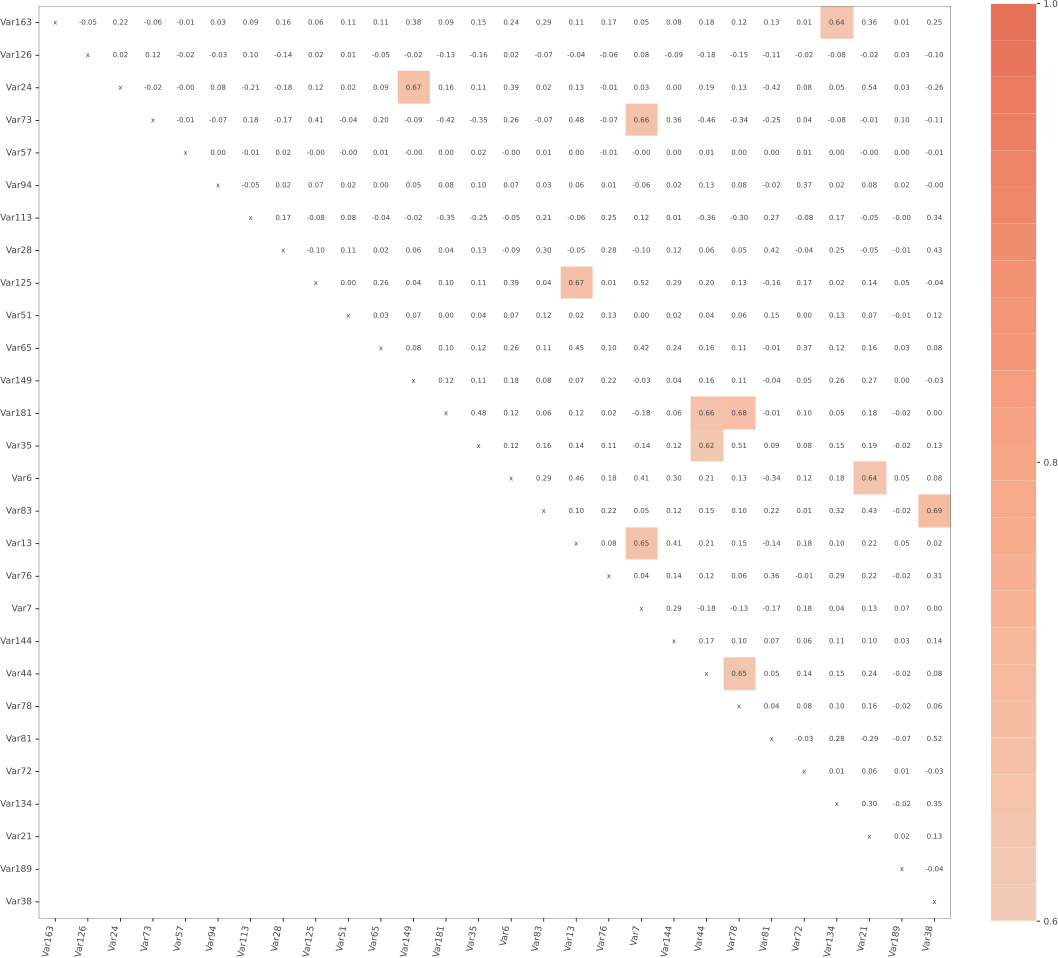

In [109]:
viz = plot_corr_heatmap(X_balanced_scaled[set(continuous_cols) - set(to_drop)], figsize=(15,15), label_fontsize=9, value_fontsize=7)
viz

# Modeling

## General functions

In [110]:
def cv_optimize(clf, parameters, X, y, n_jobs=-1, n_folds=5, score_func=None):
    if score_func:
        print("SCORE FUNC", score_func)
        gs = GridSearchCV(clf, param_grid=parameters, cv=n_folds, n_jobs=n_jobs, scoring=score_func)
    else:
        gs = GridSearchCV(clf, param_grid=parameters, n_jobs=n_jobs, cv=n_folds)
    gs.fit(X, y)
    print("BEST", gs.best_params_, gs.best_score_)
    best = gs.best_estimator_
    return best

In [111]:
def do_classify(clf, parameters, X_train, y_train, X_val, y_val, 
                featurenames, 
                score_func, n_folds=5, n_jobs=-1):
    if parameters:
        clf = cv_optimize(clf, parameters, X_train, y_train, n_jobs=n_jobs, n_folds=n_folds, score_func=score_func)
    clf=clf.fit(X_train, y_train)
    train_score = clf.score(X_train, y_train)
    val_score = clf.score(X_val, y_val)
    print("############# based on standard predict 0.5 ################")
    print("ROC AUC score on training data: %0.2f" % (train_score))
    print("ROC AUC precision score on validation data:     %0.2f" % (val_score))
    print(confusion_matrix(y_val, clf.predict(X_val)))
    print("########################################################")
    return clf, dict(X_train=X_train, y_train=y_train, X_val=X_val, y_val=y_val)

In [112]:
def make_roc(name, clf, ytest, xtest, ax=None, labe=5,  proba=True, skip=0, initial = False):
    if not ax:
        ax=plt.gca()
    if proba:
        fpr, tpr, thresholds=roc_curve(ytest, clf.predict_proba(xtest)[:,1])
    else:
        fpr, tpr, thresholds=roc_curve(ytest, clf.decision_function(xtest))
    roc_auc = auc(fpr, tpr)
    if skip:
        l=fpr.shape[0]
        ax.plot(fpr[0:l:skip], tpr[0:l:skip], '.-', lw=2, alpha=0.4, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    else:
        ax.plot(fpr, tpr, '.-', lw=2, alpha=0.4, label='ROC curve for %s (area = %0.2f)' % (name, roc_auc))
    label_kwargs = {}
    label_kwargs['bbox'] = dict(
        boxstyle='round,pad=0.3', alpha=0.2,
    )
    for k in range(0, fpr.shape[0],labe):
        #from https://gist.github.com/podshumok/c1d1c9394335d86255b8
        threshold = str(np.round(thresholds[k], 2))
        ax.annotate(threshold, (fpr[k], tpr[k]), **label_kwargs)
    if initial:
        ax.plot([0, 1], [0, 1], 'k--')
        ax.set_xlim([0.0, 1.0])
        ax.set_ylim([0.0, 1.05])
        ax.set_xlabel('False Positive Rate')
        ax.set_ylabel('True Positive Rate')
        ax.set_title('ROC')
    ax.legend(loc="lower right")
    return ax

# XGBoost

In [113]:
import xgboost as xgb
xgb = xgb.XGBClassifier()
# param_grid_xgb = { "n_estimators": [300,350,400,450,500,1000], "max_depth": [3,4,5,6,7,8,9], "learning_rate":[0.03,0.01,0.1]}
best_params_xgb = {'learning_rate': [0.1], 'max_depth': [9], 'n_estimators': [1000]}

In [122]:
filename = '/content/drive/MyDrive/Colab files/Project - ML2/xgb_best'
# pickle.dump(xgb_best, open(filename, 'wb'))
xgb_best = pickle.load(filename,'rb')

In [114]:
# xgb_best, _ = do_classify(xgb, best_params_xgb, X_balanced_scaled, y_balanced, X_val_scaled, y_val.values, X_balanced_scaled.columns, score_func='roc_auc')

SCORE FUNC roc_auc
BEST {'learning_rate': 0.1, 'max_depth': 9, 'n_estimators': 1000} 0.9736173156519932
############# based on standard predict 0.5 ################
ROC AUC score on training data: 1.00
ROC AUC precision score on validation data:     0.91
[[8926  340]
 [ 605  129]]
########################################################


In [115]:
# xgb_clf, _ = do_classify(xgb, param_grid_xgb, X_balanced_scaled, y_balanced, X_val_scaled, y_val.values, X_balanced_scaled.columns, score_func='roc_auc')

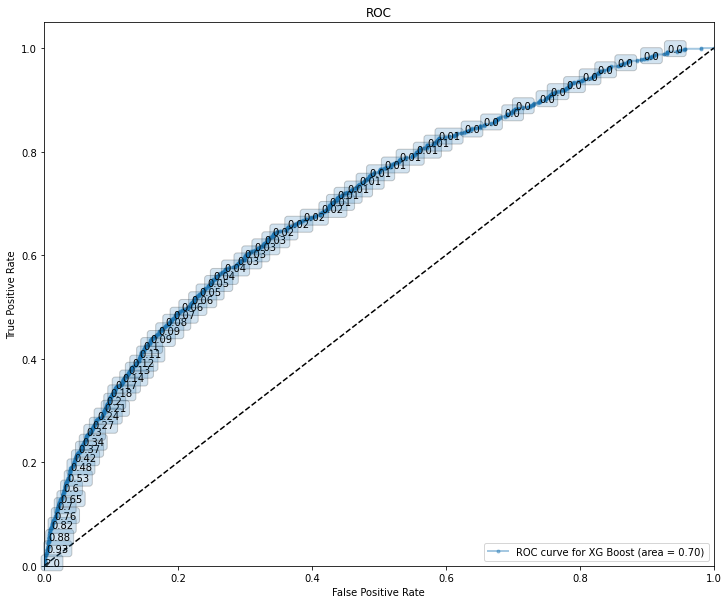

In [125]:
fig, ax = plt.subplots(figsize=(12,10))
make_roc('XG Boost',xgb_best,y_val.values,X_val_scaled,ax=ax,labe=20,initial=True)

In [119]:
print(classification_report(y_val.values, xgb_best.predict(X_val_scaled)))

              precision    recall  f1-score   support

         0.0       0.94      0.96      0.95      9266
         1.0       0.28      0.18      0.21       734

    accuracy                           0.91     10000
   macro avg       0.61      0.57      0.58     10000
weighted avg       0.89      0.91      0.90     10000



In [121]:
fbeta_score(xgb_best.predict(X_val_scaled),y_val.values,beta=2)

0.24712643678160917